# Welcome to Colorful Flavor!
This is the first part of the **MtG Classy Flavor** project. Here we will be classifying a card's color from its flavor text. We will go over getting cards from the Scryfall API, parsing the card data with Pandas, and fitting a classifier with Scikit-Learn.  

## Get Card Data from Scryfall using the Scryfall API
**Scryfall** is a powerful database and search engine for Magic: The Gathering cards. 
We will use their API to download the card data as a JSON file. We then convert the data to a pandas dataframe and isolate unique instances of flavor text.

https://scryfall.com/docs/api \
https://scryfall.com/docs/api/bulk-data


In [1]:
import requests,time,os
import numpy as np
import pandas as pd
import CF_standard_functions as cf# Custom functions
import pickle as pkl
from pathlib import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


First we query Scryfall to find the URI of the most up-to-date batch of card data. We want the address of the 'default_cards' dataset, which contains all unique prints of all cards. Once we have this address, we use it to download the raw card data.

We then save the data locally with Pickle, so we can reload it without bothering Scryfall.

In [2]:
# Set these directories to determine where to save/load the data from:
savepath = "card_data"
filename = "CardData.pkl"
fullpath = Path(savepath,filename)
# Directory for getting data from Scryfall:
sf_bulk_url = "https://api.scryfall.com/bulk-data"

if (fullpath.is_file()) and (cf.file_age_in_hours(fullpath) < 24):
    print('Loading card data from file...')
    with open(fullpath,'rb') as datafile:
        data = pkl.load(datafile)
    print('Done!')
else:
    # Load raw data file and parse into dictionary
    print('Downloading data from Scryfall')
    sf_response = requests.get(sf_bulk_url).json()
    download_dict = [d for d in sf_response['data'] if d['type'] == 'default_cards'][0]
    data_size = np.round(download_dict['size'] / 1e6,1)
    print(f"Downloading {data_size} MB of card data...")
    card_data_raw = requests.get(download_dict['download_uri']).json()
    print("Download complete!")
    # Convert to dataframe and trim to English cards from "normal" sets
    data = pd.DataFrame(card_data_raw)
    data.drop(data.index[data['set_type'] == 'funny'],inplace=True)
    data.drop(data.index[data['lang']!='en'],inplace=True)
    data.drop(data.index[data['flavor_text'].isnull()],inplace=True)
    data['flavor_text'] = data.flavor_text.apply(lambda x : x.lower())
    data.drop_duplicates(subset ='flavor_text',inplace=True)
    print("Saving data to local file...")
    if not Path(savepath).is_dir():
        Path(savepath).mkdir()
    with open(fullpath,'wb') as datafile:
        pkl.dump(data,datafile)
    print('Done!')
    
nCards = data.shape[0]
print(f"{nCards} cards with unique flavor text in data set")

Download complete!
Saving data to local file...
Done!
22867 cards with unique flavor text in data set


### Organize cards by color
In our first task we will classify flavor text by color. For convenience, we will make a new dataframe subsetting only the name, flavortext, and color of monocolored cards (i.e. excluding cards that have no color or are multiple colors).\
To make separating cards by colors easier, we add a Boolean variable to the dataframe for each color. We also add a Boolean for whether or not a card is monocolored. \
Finally, sort our cards in traditional **WUBRG** order (**W**hite, Bl**u**E, **B**lack, **R**ed, **G**reen) by setting the _colors_ variable to a categorical value.


In [3]:
for c in ['W','U','B','R','G']:
    tf = data.colors.apply(lambda x : np.shape(x) != (0,) and np.any(np.isin(x,c)))
    data['is_'+c] = tf

data['is_monocolor'] = np.sum(data.loc[:][['is_W','is_U','is_B','is_R','is_G']],axis=1) == 1

data_monocolor = data.loc[data.is_monocolor][['name','colors','flavor_text']].copy()
data_monocolor['colors'] = data_monocolor.colors.apply(lambda x: ''.join(x)) # Convert from list to string

data_monocolor['colors'] = pd.Categorical(data_monocolor['colors'],ordered=True)
data_monocolor['colors'] = data_monocolor['colors'].cat.reorder_categories(['W','U','B','R','G'])
data_monocolor.sort_values('colors',ascending=True,inplace=True)
data_monocolor.sample(5)

,name,colors,flavor_text
8375,Phyrexian Denouncer,B,"""the first stage of the illness: rash and naus..."
34116,Moat Piranhas,U,"""come on, it's not even that deep!""\n—gorin th..."
21502,Vigilant Baloth,G,villagers employ watchdogs as guardians and co...
13317,Savannah Lions,W,the traditional kings of the jungle command a ...
6056,Mardu Scout,R,"the mardu all enjoy war, but only the goblins ..."


### Prepare data for classification

We will be classifying our cards with **Scikit-Learn**. Sckit-Learn needs numerical categories, not strings. So we will map each color string to a number:

In [4]:
label_map = {'W':0,
             'U':1,
             'B':2,
             'R':3,
             'G':4}
data_monocolor['label'] = data_monocolor['colors'].map(label_map)
data_monocolor.sample(5)

,name,colors,flavor_text,label
26691,Blight Mound,B,"pests feed on carrion, mud, and one another.",2
15431,Kamahl's Druidic Vow,G,"centuries ago, a barbarian laid his rage to rest.",4
59189,Magus of the Arena,R,the magus still hears the roar of the crowds. ...,3
13158,Drooling Ogre,R,"""is it the stomping kind or the munching kind?...",3
50912,Graven Lore,U,"the runes glow beneath the snow, bearing memor...",1


### Split data into train and test sets

Using ScikitLearn's train_test_split, split our ~16,000 cards into a training set (75%) and a test set (25%). 

In [5]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monocolor['flavor_text'], data_monocolor['label'], test_size=0.25, random_state=42)

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')


Training set consists of 13015 cards.
Test set consists of 4339 cards.


## Design our Model!
First we _tokenize_ the words in flavor text and convert them to numeric values, ignoring terms that are extremely common and those that only appear 3 or fewer times in the training set. \
Then, we fit a Linear Support Vector Classifier on our training data. \
These two steps can be wrapped up together in a ScikitLearn Pipeline object.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(min_df = 3,max_df=0.95)
my_linSVC = LinearSVC(C=1)
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',my_linSVC)])

pipe = pipe.fit(flavor_train,label_train)

#### Measure model accuracy on test data

In [7]:
label_predict = pipe.predict(flavor_test)
performance = sum(label_predict == label_test) / len(label_test) * 100
print(f"Classifier accuracy is {np.round(performance,1)}%")

Classifier accuracy is 50.1%


#### Visualize model performance with a confusion matrix

              precision    recall  f1-score   support

           W       0.48      0.50      0.49       898
           U       0.48      0.50      0.49       825
           B       0.54      0.49      0.51       899
           R       0.50      0.50      0.50       870
           G       0.52      0.53      0.52       847

    accuracy                           0.50      4339
   macro avg       0.50      0.50      0.50      4339
weighted avg       0.50      0.50      0.50      4339



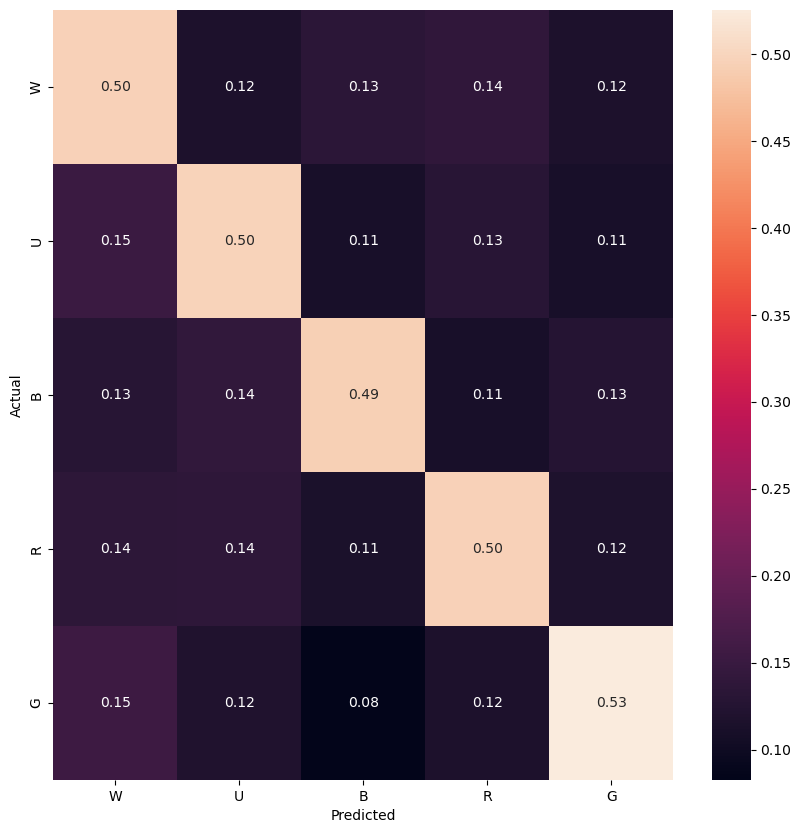

In [8]:
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt

print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in label_map]))

cm = metrics.confusion_matrix(label_test, label_predict,normalize='true',
                              labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in label_map],yticklabels=[str(i) for i in label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


**Not too shabby!** \
Our classifier gets the correct color a hair over 50% of the time. This might not seem very accurate, but remember that there are five colors, so we would only have about a 20% hit rate by randomly guessing. 

We can also write our own flavor text and see what color our model thinks it belongs to!

In [9]:
new_flavor_text = ['Goblins sure do smell bad',
              'Your spell was a mistake and now it is gone',
              'Trees are the most beautiful thing',
              'Death cannot stop the wicked',
              'The angelic choir sings loftily over the clouds',
              '"Some like it hot" -Chandra Nalaar']

new_color_predictions = pipe.predict(new_flavor_text)
# Reverse-lookup color mapping    
for txt,col in zip(new_flavor_text,new_color_predictions):
    print(f"{txt} --> {[str(i) for i in label_map][col]}")

Goblins sure do smell bad --> R
Your spell was a mistake and now it is gone --> U
Trees are the most beautiful thing --> G
Death cannot stop the wicked --> B
The angelic choir sings loftily over the clouds --> W
"Some like it hot" -Chandra Nalaar --> R


**Lets see if we can do better by tokenizing word pairs as well as individual words**

In [10]:
performance = sum(label_predict == label_test) / len(label_test)*100
print(f'Classifier hit rate is {np.round(performance,1)}%')
pipe.set_params(vect__ngram_range = (1,2))
pipe.fit(flavor_train,label_train)
color_predict = pipe.predict(flavor_test)


Classifier hit rate is 50.1%


Looks like that didn't make a difference. Lets do a more thorough optimization using a parameter grid search:
(this takes a long time to run, check the Python kernal for progress updates)

In [11]:
from sklearn.model_selection import GridSearchCV 

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)] ,
    'vect__max_df': [0.8,0.9,0.95,0.99],
    'vect__min_df': [1,2,3],
    'clf__C':       [0.01,0.1,1]}
gs = GridSearchCV(pipe, parameters, n_jobs=-1,verbose=3)
gs.fit(flavor_train,label_train)

gs_df = pd.DataFrame.from_dict(gs.cv_results_)

print(gs.best_score_)
print(gs.best_params_)
gs_df.head()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.5041874759892432
{'clf__C': 0.1, 'vect__max_df': 0.8, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193324,0.016006,0.035667,0.004035,0.01,0.8,1,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.462927,0.451402,0.452171,0.447561,0.434883,0.449789,0.009034,57
1,0.598050,0.013588,0.072708,0.002367,0.01,0.8,1,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.440261,0.429120,0.429504,0.429889,0.416443,0.429043,0.007557,69
2,0.378064,0.024719,0.036672,0.003216,0.01,0.8,2,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.458317,0.452171,0.450634,0.453323,0.438340,0.450557,0.006629,49
3,0.406985,0.009893,0.063596,0.009056,0.01,0.8,2,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.451018,0.446792,0.445255,0.444487,0.422589,0.442028,0.009978,65
4,0.324524,0.013837,0.032858,0.003311,0.01,0.8,3,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.459086,0.452939,0.451402,0.453707,0.434883,0.450403,0.008181,53


**Plot the relationships between model parameters and model score**

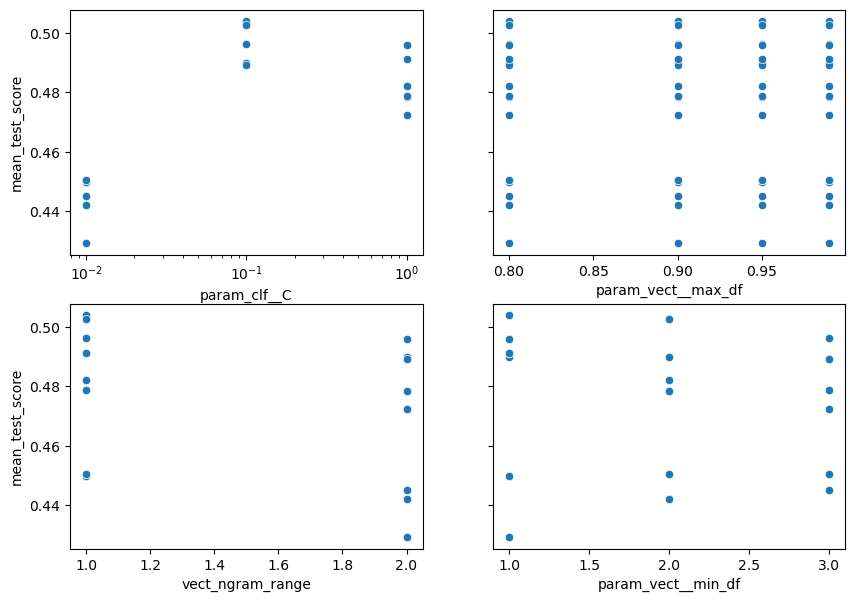

In [12]:
fig,ax = plt.subplots(2,2,sharey=True,figsize=[10,7])
sns.scatterplot(data=gs_df,ax=ax[0][0],x='param_clf__C',y='mean_test_score')
sns.scatterplot(data=gs_df,ax=ax[0][1],x='param_vect__max_df',y='mean_test_score')
ngram_range_max = [i[1] for i in gs_df.loc[:,'param_vect__ngram_range']]
sns.scatterplot(data=gs_df,ax=ax[1][0],x=ngram_range_max,y='mean_test_score')
ax[1][0].set_xlabel('vect_ngram_range')
sns.scatterplot(data=gs_df,ax=ax[1][1],x='param_vect__min_df',y='mean_test_score')
ax[0][0].set_xscale('log')

From these plots, it looks like the C parameter of the LinearSVC is the most important parameter to adjust, though differences in how we vectorize the text can help a bit.\
_max_cf_ has little effect, and a higher _max_cf_ value means we are removing more words from our lexicon, so let's leave that at 0.95 to keep more words in our model without hurting performance.

**Retrain the model with these new parameters**

In [13]:
pipe.set_params(vect__max_df = 0.95,
                vect__min_df=1,
                vect__ngram_range=(1,1),
                clf__C = 0.1)
pipe.fit(flavor_train,label_train)
label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 4)*100
print('Optimized classifier hit rate is %s%%' % np.round(performance,1))

Optimized classifier hit rate is 51.2%


## Investigate the Model
Now that we have an optimized model, lets look into what types of text the model does well or poorly on. \
For now, we will only look at cards in our test set (to avoid re-running the model several times). 

One likely cause of misclassification is from cards with very short flavor text. We can check this by plotting the portion of correct classifications as a function of flavor text length.

First, let's look at the distribution of the number of words in flavor text, binning by 5 words:

[Text(0, 0.5, 'Count of Cards'),
 Text(0.5, 0, 'Number of Words in Flavor Text')]

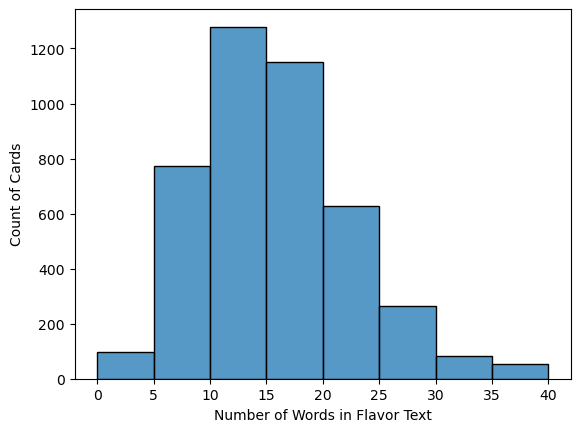

In [14]:
# Put test data into a dataframe for easier plotting and indexing
test_df = pd.DataFrame(data={'flavor_text':flavor_test,'label':label_test})
test_df['word_count'] = test_df.flavor_text.apply(lambda x : len(x.split()))
test_df['predicted'] = pipe.predict(test_df['flavor_text'])
test_df['correct'] = np.equal(test_df['label'],test_df['predicted'])
test_df = pd.concat([test_df,data_monocolor['name']],axis=1,join='inner')
test_df = test_df[['name','flavor_text','word_count','label','predicted','correct']]

bins = np.arange(0,45,5)
ax = plt.axes()
sns.histplot(data=test_df,x='word_count',bins=bins,ax=ax)
ax.set(ylabel='Count of Cards',xlabel='Number of Words in Flavor Text')

Now for each bin, find the proportion of cards in that bin that are correctly classified:

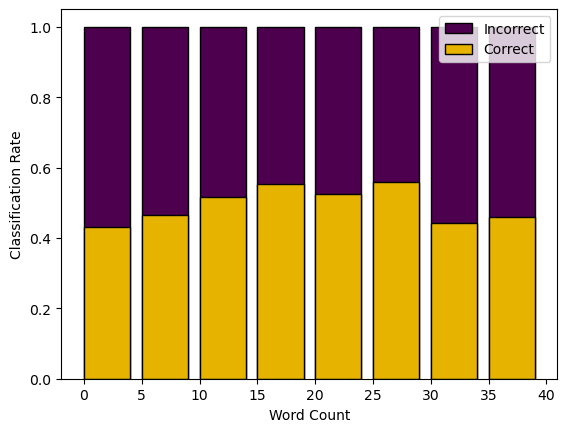

In [15]:
# Preallocate arrays
counts_correct = np.zeros(len(bins)-1)
counts_all =   np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sub_data = test_df[(test_df.word_count > bins[i]) & (test_df.word_count <= bins[i+1])]
    counts_correct[i] = sum(sub_data.correct)
    counts_all[i] = sub_data.shape[0]
plot_bin_width = (bins[1]-bins[0])*0.8
    
hit_rate = counts_correct / counts_all
bar_x = [np.mean([y,z]) for y,z in zip(bins[:-1],bins[1:])]
bar_df = pd.DataFrame({'Bin':bins[:-1],'Correct_Rate':hit_rate,'Incorrect_Rate':1-np.array(hit_rate)})
miss_bar = plt.bar(bins[:-1],np.ones(np.size(hit_rate)),align='edge',width=plot_bin_width,
                   edgecolor='k',color=[0.3,0,0.3])
hit_bar = plt.bar(bins[:-1],hit_rate,align='edge',width=plot_bin_width,
                  edgecolor='k',color=[0.9,0.7,0])
plt.ylabel('Classification Rate')
plt.xlabel('Word Count')
miss_bar.set_label('Incorrect')
hit_bar.set_label('Correct')
plt.legend()

It looks like there might be a weak relationship between word count and classifier accuracy. We can test this hypothesis with a simple logistic regression:

In [16]:
from scipy.special import expit # Logistic sigmoid function
import statsmodels.api as sm
from scipy import stats

X = np.array(test_df['word_count'])
y = test_df['correct']
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

ModuleNotFoundError: No module named 'statsmodels'

[CV 4/5] END clf__C=0.01, vect__max_df=0.8, vect__min_df=1, vect__ngram_range=(1, 1);, score=0.448 total time=   0.2s
[CV 1/5] END clf__C=0.01, vect__max_df=0.8, vect__min_df=2, vect__ngram_range=(1, 1);, score=0.458 total time=   0.4s
[CV 4/5] END clf__C=0.01, vect__max_df=0.8, vect__min_df=2, vect__ngram_range=(1, 1);, score=0.453 total time=   0.4s
[CV 2/5] END clf__C=0.01, vect__max_df=0.8, vect__min_df=3, vect__ngram_range=(1, 1);, score=0.453 total time=   0.4s
[CV 5/5] END clf__C=0.01, vect__max_df=0.8, vect__min_df=3, vect__ngram_range=(1, 2);, score=0.424 total time=   0.4s
[CV 1/5] END clf__C=0.01, vect__max_df=0.9, vect__min_df=2, vect__ngram_range=(1, 1);, score=0.458 total time=   0.5s
[CV 5/5] END clf__C=0.01, vect__max_df=0.9, vect__min_df=2, vect__ngram_range=(1, 1);, score=0.438 total time=   0.4s
[CV 3/5] END clf__C=0.01, vect__max_df=0.9, vect__min_df=3, vect__ngram_range=(1, 1);, score=0.451 total time=   0.3s
[CV 1/5] END clf__C=0.01, vect__max_df=0.95, vect__min_d

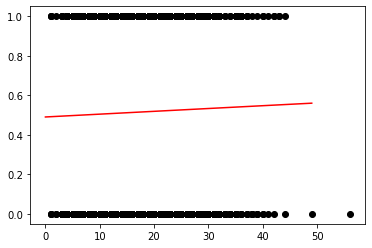

In [18]:
X_predict = np.arange(0,50)
X_predict = sm.add_constant(X_predict)
pred = model.predict(X_predict)
plt.plot(X_predict[:,1],pred,color='r')
plt.scatter(test_df['word_count'],test_df['correct'],color='k')

This model is significant, but only explains a tiny fraction of the variance in the data (low R<sup>2</sup>). So our classifier performs only marginally better on longer pieces of text.

In [19]:
label_map_inv = {v: k for k, v in label_map.items()}
test_df['label_color'] = test_df['label'].map(label_map_inv)
test_df['predicted_color'] = test_df['predicted'].map(label_map_inv)


pd.set_option('display.max_colwidth', None)
test_df[test_df.correct == False]

,name,flavor_text,word_count,label,predicted,correct,label_color,predicted_color
67238,Death's Presence,the genestealer cults rejoiced at the arrival of their gods . . . at first.,15,4,0,False,G,W
32709,Spellseeker,"not content with mere answers, she hunts for the truth.",10,1,0,False,U,W
43124,Virulent Wound,"sadly, the extent of gerkk's healing knowledge was ""don't pick at it.""",12,2,1,False,B,U
43092,Infuriate,"""no shirt, no shoes, no service.""\n—marketplace sign",8,3,2,False,R,B
80908,Setessan Oathsworn,"""setessa is not the city of my birth, but it is the place i fight for, and the place i'm willing to die for. does that not make it my home?""",31,4,0,False,G,W
...,...,...,...,...,...,...,...,...
1815,Aegis of the Heavens,inner strength is never seen until it makes all the difference.,11,0,4,False,W,G
9995,Claws of Valakut,"""swords may sunder. shields may fail. my will is stronger than steel, and my flesh and bone far more deadly.""",20,3,0,False,R,W
78094,Goblin Lackey,"""danger"" was supposed to be babysitting, so ""little angel"" became the newest member of the team.",16,3,0,False,R,W
51446,Rally Maneuver,"""don't give up! you are steel and fire, and victory is yours to seize.""",14,0,3,False,W,R
